### Things to do

- ?
    - Official adaptation rate method
    - Hemisphere
    - Bin length is +.1 or *.1
- Analyze blocked and shuffled data in NCM and Field L
    - Check if there is a difference between NCM and Field L
    - Determine if there is a loss of decoding accuracy accross stimulus repetition
    - Hemispheric differences?
    - Analyze single unit data in a similar fashion
    - Figure out why part of shuffled data appears to be corrupted
   
- Analyze contrast data
    - Compare decoding accuracy between first and second half of presentations

1. Add new files to the npz
2. Analyze contrast
    a. ncm vs l
    b. left vs right
    c. Plot decoding accuracy x trial numbver 
3. Plot decoding accuracy x trial number for Shuffled and blocked
4. See if I can get contrast condition working
5. Send to David and Ming

In [1]:
import mdlab as mdl
import dnlab as dnl
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import scipy.stats as sst
import pandas as pd
import pdb

In [2]:
frcc=mdl.FRCC()
trailing_type = frcc.trailing_type
trailing_param = frcc.get_trailing_param(trailing_type)
stats_test = frcc.stats_test

In [47]:
fn = mdl.get_pathname()

In [ ]:
fn2 = mdl.get_pathname()

In [7]:
mdl.batch_mat2npz("hv_ncm_contrast.npz")

matrix_BL008__contrast_.mat
matrix_DG138__contrast_.mat
matrix_GR009__contrast_.mat
matrix_HS001__contrast_.mat
matrix_HS003__contrast_.mat
matrix_HS004__contrast_444_.mat
matrix_HS005__contrast_.mat
matrix_HS100__contrast_.mat
matrix_LG146__contrast_.mat
matrix_PK121__contrast_.mat


In [3]:
fn = mdl.get_pathname()
header, spikes = mdl.load_npz_data(fn, False)
ncm_block = mdl.SpikeData(header, spikes)
ncm_mua_block=ncm_block.mua_or_sua("mua")
ncm_sep_mua_block = dnl.separate_npz_data(ncm_mua_block)
res_ncm_block = dnl.res_filter(ncm_sep_mua_block)

In [3]:
fn = mdl.get_pathname()
header, spikes = mdl.load_npz_data(fn, False)
ncm_contrast = mdl.SpikeData(header, spikes)
ncm_mua_contrast=ncm_contrast.mua_or_sua("mua")
ncm_sep_mua_contrast = dnl.separate_npz_data(ncm_mua_contrast)
res_ncm_contrast = dnl.res_filter(ncm_sep_mua_contrast)
#ncm_contrast_df = dnl.batch_decoding_accuracy(res_ncm_contrast)

In [ ]:
ncm_contrast_df = dnl.batch_decoding_accuracy(res_ncm_contrast)

1 Experiments Analyzed
2 Experiments Analyzed


In [ ]:
1+1

In [ ]:
# back up dataframe

In [ ]:
# check to see if 

In [ ]:
n =0
for ele in ncm_sep_mua_block[n].electrodes:
    ele_data = ncm_sep_mua_block[n].get_kw_SpikeData(electrode = ele)
    print mdl.birdid2str(ele_data.birdid[0])
    print ele
    if ele in res_ncm_block[n].electrodes:
        print "Responding"
    else:
        print "Not Responding"
    mdl.raster_plot(ele_data.spikes)
    plt.show()

In [12]:
n =0
for ele in sep_mua_block[n].electrodes:
    ele_data = sep_mua_block[n].get_kw_SpikeData(electrode = ele)
    print mdl.birdid2str(ele_data.birdid[0])
    print ele
    if ele in res_block[n].electrodes:
        print "Responding"
    else:
        print "Not Responding"
    mdl.raster_plot(ele_data.spikes)
    plt.show()

NameError: name 'sep_mua_block' is not defined

In [5]:
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split as split

In [6]:
# Need to create wit-wet translation guide
def contrast_decoding_accuracy(electrode, k=15):
    # Generates parameters for acc and trial_usage
    num_stim = len(electrode.stim)
    total_trials = electrode.header.shape[0]
    trials_per_stim = total_trials/num_stim
    acc = np.zeros((num_stim, trials_per_stim))
    longest_stim = dnl.get_longest_stim(electrode)
    #2D array #2D arra`y, stim id x the trials per stimulus, increments up by one every time given trial used as target
    trial_usage = np.zeros((num_stim, trials_per_stim))

    training_data = dnl.Spike_to_Binned(electrode.get_kw_SpikeData(trial = range(1, 161)), custom_stim_length = longest_stim)
    training_bins = training_data.bins
    training_idx = training_data.header.index.values
    training_stim_ids=np.array(training_data.header.stim)
    
    target_data = dnl.Spike_to_Binned(electrode.get_kw_SpikeData(trial = range(161, 321)), custom_stim_length = longest_stim)
    target_bins = target_data.bins
    target_idx = target_data.header.index.values
    target_stim_ids=np.array(target_data.header.stim)

    model = knn(n_neighbors=k, metric='euclidean')
    model.fit(training_bins, training_stim_ids)
    pred = model.predict(target_bins)





    #Checks to see if predictions are correct
    for j in range(0, pred.shape[0]):
        stim_id= target_stim_ids[j]
        idx = target_idx[j]
        stim_data = electrode.get_kw_SpikeData(stim=stim_id)
        net_trial_num = stim_data.header.loc[idx:idx].trial.max()
        mod_stim_data_header = stim_data.header.reset_index()
        true_trial_num = mod_stim_data_header[(mod_stim_data_header["trial"] == net_trial_num)].index[0]
        #increament trial usageb
        trial_usage[stim_id-1][true_trial_num]+=1
        
        trial_stim_category = pred[j] % 2
        true_stim_category = stim_id % 2
        if trial_stim_category == true_stim_category:
            acc[stim_id-1][true_trial_num] += 1
       #pdb.set_trace()
            
    #inal_acc = np.divide(acc, trial_usage)
    return acc

In [7]:
# does the knn algorithm on an array of experiments
def batch_contrast_decoding_accuracy(split_data, region = "N/A", n_neighbors=15, training=.5):
    # Runs the decoding accuracy KNN algorithm on an array of spike data objects
    # split_data is the spike data array, bird_ele_class is a dataframe containing all responding electrodes and the 
    # region they are from.    
    # n neighbors is the amount of neighbors for the knn algorithm
    # reps is the amount of repitions of the algorithm to run
    # training is the training proportion
    
    c = ['birdid','electrode', 'region', 'hemisphere', 'average_adaptation_rate','average_decoding_accuracy','decoding_accuracy']
    final_df = pd.DataFrame(columns = c)
    #loops through split data
    n = 1
    for spike_data in split_data:
        ele_num_arr = spike_data.electrodes
        bird_tag = chr(int(str(spike_data.birdid[0])[0:2])) + chr(int(str(spike_data.birdid[0])[2:4]))
        bird_id = bird_tag + str(spike_data.birdid[0])[-5:-2]
        for x, ele_num in enumerate(ele_num_arr):
            try:
                ele_spike_data = spike_data.get_kw_SpikeData(electrode = ele_num)
                #ele_binned_data = dnl.Spike_to_Binned(ele_spike_data)
                decoding_acc = contrast_decoding_accuracy(ele_spike_data, k=n_neighbors)[4:]
                avg_decoding_acc = np.mean(decoding_acc)
            except:
                pdb.set_trace()
            if ele_num < 1600:
                to_add = [bird_id, ele_num, region, "Left", dnl.get_adaptation_rate(ele_spike_data)[ele_num],avg_decoding_acc, decoding_acc]
                final_df = final_df.append(pd.DataFrame([to_add], columns=c)) 
            else:
                to_add = [bird_id, ele_num, region, "Right", dnl.get_adaptation_rate(ele_spike_data)[ele_num], avg_decoding_acc, decoding_acc]
                final_df = final_df.append(pd.DataFrame([to_add], columns=c))
        print str(n)+" Experiments Analyzed"
        n+=1
    return final_df.reset_index(drop=True)

In [8]:
n_neighbors = 15
rep_num = 250
bin_size = .01
training_prop=.5
resolution = .0001

In [9]:
def make_bins(SpikeData, step_size=bin_size, custom_stim_length = None):
    resolution = SpikeData.header.resolution.max()
    ap_matrix=[]
    spikes=SpikeData.spikes
    pre_stim_dur = SpikeData.header.pre_stim.max()
    if custom_stim_length is not None:
        longest_stim_dur = custom_stim_length
    else:
        longest_stim_dur = dnl.get_longest_stim(SpikeData)
    bin_start = int(pre_stim_dur/resolution)
    bin_end = int(((longest_stim_dur+.1)/resolution)+bin_start)
    for trial in spikes:
        trial = trial[bin_start:bin_end]
        nu=round(trial.shape[0]*resolution/step_size)
        split_trial=np.array(np.split(trial, nu))
        ap_matrix.append(sst.zscore(np.sum(split_trial, axis=1)))
    bins=np.array(ap_matrix)
    bins = np.nan_to_num(bins)
    return bins

In [28]:
print str(len(contrast_df)) + " total sites"
print str(len(ncm)) + " NCM sites"
print str(len(fieldl)) + " Field L sites"

333 total sites
204 NCM sites
129 Field L sites


In [50]:
contrast_df.index

RangeIndex(start=0, stop=333, step=1)

In [54]:
contrast_df = pd.read_csv("contrast_df.csv")
ncm = contrast_df[(contrast_df["region"] == "NCM")]
fieldl = contrast_df[(contrast_df["region"] == "Field L")]

In [65]:
ncm

,Unnamed: 0,birdid,electrode,region,hemisphere,average_adaptation_rate,average_decoding_accuracy,decoding_accuracy,trial_decoding_acc
129,0,BL008,100,NCM,Left,-0.004830,0.234558,[[0.00787402 0.048 0. 0. ...,[0.29868246 0.21574125 0.25669664 0.40092805 0...
130,1,BL008,200,NCM,Left,-0.007761,0.257269,[[0.008 0.01526718 0. 0.26811594 ...,[0.15528437 0.26084082 0.25465196 0.267592 0...
131,2,BL008,300,NCM,Left,-0.011955,0.279300,[[0.20512821 0.10655738 0.01626016 0.86956522 ...,[0.31461605 0.32994279 0.23583462 0.24220844 0...
132,3,BL008,400,NCM,Left,-0.009844,0.504943,[[0. 0.82539683 0.94117647 0.5203252 ...,[0.32159212 0.46555226 0.66341009 0.51427955 0...
133,4,BL008,500,NCM,Left,-0.009303,0.294856,[[0.5035461 0.30172414 0.85714286 0.42857143 ...,[0.22611501 0.27896496 0.28025698 0.34063286 0...
134,5,BL008,600,NCM,Left,-0.010245,0.303094,[[0.24107143 0.00813008 0.73809524 0.01785714 ...,[0.27764114 0.39379038 0.36799232 0.33215626 0...
135,6,BL008,700,NCM,Left,-0.013244,0.513240,[[0.528 0.00775194 0.68181818 0.94244604 ...,[0.51233465 0.29932127 0.43817817 0.48574172 0...
136,7,BL008,800,NCM,Left,-0.004981,0.398074,[[0.47286822 0.18487395 0.57246377 0.52380952 ...,[0.4087055 0.34438016 0.2394621 0.41111486 0...
137,8,BL008,900,NCM,Left,-0.011154,0.245370,[[0. 0.02083333 0. 0. ...,[0.18140431 0.25133719 0.13691923 0.22917673 0...
138,9,BL008,1000,NCM,Left,-0.010917,0.256941,[[0.67857143 0. 0.71323529 0.00840336 ...,[0.18888374 0.15342861 0.33646474 0.2011882 0...


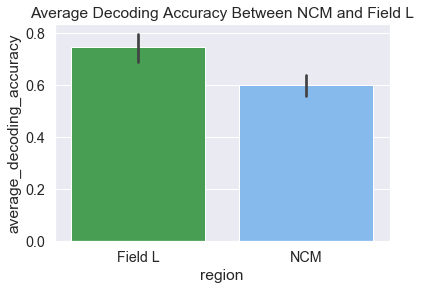

P Value = 1.225611472308379e-05


In [6]:
sns.set(font_scale = 1.3)
col_list = ["medium green", "sky blue"]
col_list_palette = sns.xkcd_palette(col_list)
sns.set_palette(col_list_palette)
sns.barplot(x="region", y='average_decoding_accuracy', data=contrast_df)
stat,pval = sst.ttest_ind(ncm.average_decoding_accuracy , fieldl.average_decoding_accuracy)
plt.title("Average Decoding Accuracy Between NCM and Field L")
plt.show()
print "P Value = "+str(pval)

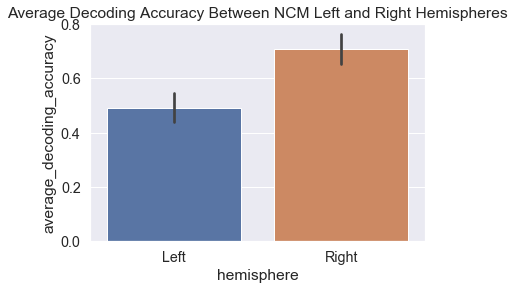

P Value = 5.495304411644999e-08


In [43]:
sns.set(font_scale = 1.3)
sns.set_palette("deep")
sns.barplot(x="hemisphere", y='average_decoding_accuracy', data=ncm)
stat,pval = sst.ttest_ind(ncm[(ncm["hemisphere"] == "Right")].average_decoding_accuracy , ncm[(ncm["hemisphere"] == "Left")].average_decoding_accuracy)
plt.title("Average Decoding Accuracy Between NCM Left and Right Hemispheres")
plt.show()
print "P Value = "+str(pval)

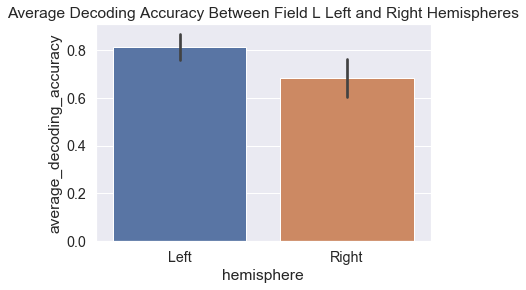

P Value = 0.012675381675286684


In [41]:
sns.set(font_scale = 1.3)
sns.set_palette("deep")
sns.barplot(x="hemisphere", y='average_decoding_accuracy', data= fieldl)
stat,pval = sst.ttest_ind(fieldl[(fieldl["hemisphere"] == "Right")].average_decoding_accuracy , fieldl[(fieldl["hemisphere"] == "Left")].average_decoding_accuracy)
plt.title("Average Decoding Accuracy Between Field L Left and Right Hemispheres")
plt.show()
print "P Value = "+str(pval)

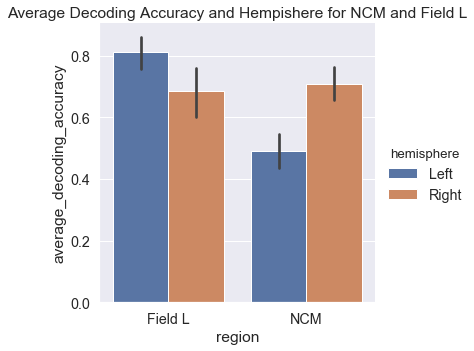

P Value for Average Decoding Accuracy between Left and Right Field L = 0.012675381675286684
P Value for Average Decoding Accuracy between Left and Right NCM = 5.495304411644999e-08


In [46]:
sns.set(font_scale = 1.3)
sns.catplot(x='region', y='average_decoding_accuracy', hue='hemisphere', data=contrast_df, kind='bar')
plt.title("Average Decoding Accuracy and Hempishere for NCM and Field L")
plt.show()
stat,pval = sst.ttest_ind(fieldl[(fieldl["hemisphere"] == "Right")].average_decoding_accuracy , fieldl[(fieldl["hemisphere"] == "Left")].average_decoding_accuracy)
print "P Value for Average Decoding Accuracy between Left and Right Field L = "+str(pval)
stat,pval = sst.ttest_ind(ncm[(ncm["hemisphere"] == "Right")].average_decoding_accuracy , ncm[(ncm["hemisphere"] == "Left")].average_decoding_accuracy)
print "P Value for Average Decoding Accuracy between Left and Right NCM = "+str(pval)


In [87]:
real_trial_decoding_acc = pd.Dataframe(columns = )
for x in ncm.trial_decoding_acc:
    x = x.replace("[","")
    x = x.replace("]","")
    x = x.replace("\n","")
    x = x.split()
    temp = []
    for y in x:
        temp.append(float(y))


NameError: name 'real_trial_decoding_acc' is not defined

In [43]:
for n in np.asarray(ncm.index):
    row = ncm.loc[n]
    da = np.asarray(row.decoding_accuracy)
    print np.mean(da)
    break

TypeError: cannot perform reduce with flexible type

In [60]:
c = ["birdid", "electrode", "region", "hemisphere", "average_adaptation_rate", "average_decoding_accuracy", "trial_decoding_accuracy"]
ncm2 = pd.DataFrame(columns = c)
for n in np.asarray(ncm.index):
    row = ncm.loc[n]
    to_add = [row.birdid, row.electrode, row.region, row.hemisphere, row.average_adaptation_rate, row.average_decoding_accuracy, np.mean(row.decoding_accuracy, axis=0)]
    ncm2 = ncm2.append(pd.DataFrame([to_add], columns=c))
    ncm2.reset_index(drop=True)

IndexError: tuple index out of range

In [158]:
trial_decoding_acc = []
for x in range(0, len(contrast_df)):
    trial_decoding_acc.append(np.mean(contrast_df.iloc[x].decoding_accuracy, axis=0))
contrast_df["trial_decoding_acc"] = trial_decoding_acc

In [160]:
contrast_df.to_csv("contrast_df.csv")

In [30]:
ncm["decoding_accuracy"].tolist()

['[[0.00787402 0.048      0.         0.         0.10833333 0.15037594\n  0.         0.03053435 0.05755396 0.         0.01680672 0.01769912\n  0.         0.03968254 0.05785124 0.05       0.57264957 0.28787879\n  0.032      0.         0.02542373 0.00813008 0.         0.\n  0.06722689 0.08695652 0.36153846 0.4214876  0.15625    0.05223881\n  0.14782609 0.03225806 0.01449275 0.06557377 0.10769231 0.21538462\n  0.         0.         0.02419355 0.32038835]\n [0.98561151 0.99122807 0.98449612 0.98058252 0.99173554 0.95275591\n  0.9921875  0.96774194 0.99173554 0.99166667 0.992      0.99224806\n  0.96825397 0.93442623 0.99275362 0.99159664 0.99056604 0.99259259\n  0.96396396 0.99137931 0.875      0.98550725 0.76923077 0.\n  0.99270073 0.96825397 0.97744361 0.98198198 0.99230769 0.99173554\n  0.96521739 0.89430894 0.99259259 0.97692308 0.31914894 0.94573643\n  0.96153846 0.75409836 0.64705882 0.79527559]\n [0.         0.         0.52       0.         0.42975207 0.\n  0.53174603 0.         0.121

In [27]:
ncm

,Unnamed: 0,birdid,electrode,region,hemisphere,average_adaptation_rate,average_decoding_accuracy,decoding_accuracy,trial_decoding_acc
129,0,BL008,100,NCM,Left,-0.004830,0.234558,[[0.00787402 0.048 0. 0. ...,[0.29868246 0.21574125 0.25669664 0.40092805 0...
130,1,BL008,200,NCM,Left,-0.007761,0.257269,[[0.008 0.01526718 0. 0.26811594 ...,[0.15528437 0.26084082 0.25465196 0.267592 0...
131,2,BL008,300,NCM,Left,-0.011955,0.279300,[[0.20512821 0.10655738 0.01626016 0.86956522 ...,[0.31461605 0.32994279 0.23583462 0.24220844 0...
132,3,BL008,400,NCM,Left,-0.009844,0.504943,[[0. 0.82539683 0.94117647 0.5203252 ...,[0.32159212 0.46555226 0.66341009 0.51427955 0...
133,4,BL008,500,NCM,Left,-0.009303,0.294856,[[0.5035461 0.30172414 0.85714286 0.42857143 ...,[0.22611501 0.27896496 0.28025698 0.34063286 0...
134,5,BL008,600,NCM,Left,-0.010245,0.303094,[[0.24107143 0.00813008 0.73809524 0.01785714 ...,[0.27764114 0.39379038 0.36799232 0.33215626 0...
135,6,BL008,700,NCM,Left,-0.013244,0.513240,[[0.528 0.00775194 0.68181818 0.94244604 ...,[0.51233465 0.29932127 0.43817817 0.48574172 0...
136,7,BL008,800,NCM,Left,-0.004981,0.398074,[[0.47286822 0.18487395 0.57246377 0.52380952 ...,[0.4087055 0.34438016 0.2394621 0.41111486 0...
137,8,BL008,900,NCM,Left,-0.011154,0.245370,[[0. 0.02083333 0. 0. ...,[0.18140431 0.25133719 0.13691923 0.22917673 0...
138,9,BL008,1000,NCM,Left,-0.010917,0.256941,[[0.67857143 0. 0.71323529 0.00840336 ...,[0.18888374 0.15342861 0.33646474 0.2011882 0...
